In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
# Mac OS jupyter kernel dies without.
import os
import pyabc

from epi.models import Model, Parameter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib
import pickle
import seaborn as sns

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12

DTYPE = np.float32

In [3]:
def plot_SNPEC_opt(logs, trn_datasets, posteriors, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,5))
    losses = [logs[i]['val_loss'] for i in range(len(logs))]
    loss = np.concatenate(losses, axis=0)
    ax.plot(loss,lw=2)
    ax.set_xlabel('iteration')
    ax.set_ylabel('val loss')
    return ax
    
def Jeigs(params):
    """Calculates Jeigs.

        Parameters
        ----------
        params : np.array, 1d of length dim_param
            Parameter vector
        seed : int
        """

    u1 = params[0,:N]
    u2 = params[0,N:(2*N)]
    v1 = params[0,(2*N):(3*N)]
    v2 = params[0,(3*N):]

    U = np.stack((u1, u2), axis=1)
    V = np.stack((v1, v2), axis=1)

    J = np.matmul(U, np.transpose(V))
    Js = (J + np.transpose(J)) / 2.
    Js_eigs = np.linalg.eigvalsh(Js)
    Js_eig_max = np.max(Js_eigs, axis=0)

    # Take eig of low rank similar mat
    Jr = np.matmul(np.transpose(V), U) + 0.0001*np.eye(2)
    Jr_tr = np.trace(Jr)
    sqrt_term = np.square(Jr_tr) + -4.*np.linalg.det(Jr)
    J_eig_realmax = 0.5 * Jr_tr
    if (sqrt_term > 0.):
        J_eig_realmax += 0.5*np.sqrt(sqrt_term)

    return np.array([J_eig_realmax, Js_eig_max])

## SMC-ABC

In [28]:
N_smcs = [2,3,4,5,6]
rs =  range(1,11)

Js_eig_max_mean = 1.5
J_eig_realmax_mean = 0.5

smc_times = []
smc_zs = []
smc_T_xs = []
for N in N_smcs:
    _smc_times = []
    
    def stable_amplification_r2(U, V):
        U = tf.reshape(U, (-1, N, 2))
        V = tf.reshape(V, (-1, N, 2))
        J = tf.matmul(U, tf.transpose(V, [0,2,1]))
        Js = (J + tf.transpose(J, [0, 2, 1])) / 2.
        Js_eigs = tf.linalg.eigvalsh(Js)
        Js_eig_max = tf.reduce_max(Js_eigs, axis=1)

        # Take eig of low rank similar mat
        Jr = tf.matmul(tf.transpose(V, [0,2,1]), U) + 0.0001*tf.eye(2)[None,:,:]
        Jr_tr = tf.linalg.trace(Jr)
        maybe_complex_term = tf.complex(tf.square(Jr_tr) + -4.*tf.linalg.det(Jr), 0.)
        J_eig_realmax = 0.5 * (Jr_tr + tf.math.real(tf.sqrt(maybe_complex_term)))

        T_x = tf.stack([Js_eig_max, tf.square(Js_eig_max-Js_eig_max_mean),
                        J_eig_realmax, tf.square(J_eig_realmax-J_eig_realmax_mean)], axis=1)
        return T_x
    
    _smc_zs = []
    _smc_T_xs = []
    for _rs in rs:
        base_path = os.path.join("data", "smc")
        save_dir = "SMC_RNN_stab_amp_N=%d_rs=%d" % (N, _rs)
        save_path = os.path.join(base_path, save_dir)

        try:
            with open(os.path.join(save_path, "optim.pkl"), "rb") as f:
                optim = pickle.load(f)
        except:
            print(os.path.join(save_path, "optim.pkl"))
            _smc_times.append(np.nan)
            continue
        history = optim["history"]
        converged = optim["converged"]
        
        if converged:
            _smc_times.append(optim['time'])
        else:
            _smc_times.append(np.nan)
            
        z = optim["z"]
        U = tf.constant(z[:, :(2*N)], dtype=tf.float32)
        V = tf.constant(z[:, (2*N):], dtype=tf.float32)
        T_x = stable_amplification_r2(U, V).numpy()
        T_x = np.stack((T_x[:,2], T_x[:,0]), axis=1)
        _smc_zs.append(z)
        _smc_T_xs.append(T_x)
        
    smc_times.append(_smc_times)
    smc_zs.append(np.array(_smc_zs))
    smc_T_xs.append(np.array(_smc_T_xs))
    
    
    
smc_times = np.array(smc_times)/3600.
smc_T_xs = np.array(smc_T_xs)

smc_time_mean = np.nanmean(smc_times, axis=1)
smc_time_std = np.nanstd(smc_times, axis=1)


data/smc/SMC_RNN_stab_amp_N=4_rs=6/optim.pkl
data/smc/SMC_RNN_stab_amp_N=6_rs=1/optim.pkl
data/smc/SMC_RNN_stab_amp_N=6_rs=5/optim.pkl
data/smc/SMC_RNN_stab_amp_N=6_rs=8/optim.pkl
data/smc/SMC_RNN_stab_amp_N=6_rs=9/optim.pkl


/Users/seanbittner/opt/anaconda3/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## SNPE

In [5]:
N_snpes = [2, 5, 10, 15, 20, 25]
N_snpe_conv = [2, 5, 10, 15, 20, 25]
n_trains = [2000, 10000, 100000]
n_mades = [2,3] 
n_atoms = 100
rs = [1, 2, 3]
plot_flg = False

def snpe_convergence(data, first=False):
    n_rounds = len(data)
    conv_rounds = []
    conv_perc = []
    for i in range(1,n_rounds):
        print("Round %d\r" % (i+1), end="")
        z = data[i][0]
        M = z.shape[0]
        T_x = np.array([Jeigs(z[i][None,:]) for i in range(M)])
        ok_samples = np.logical_and(
            np.logical_and(0. < T_x[:,0], T_x[:,0] < 1.),
            np.logical_and(1. < T_x[:,1], T_x[:,1] < 2.))
        num_ok = np.sum(ok_samples)
        if (num_ok > 1):
            if first:
                return i, (num_ok/float(M))
            conv_rounds.append(i)
            conv_perc.append(num_ok/float(M))
    return conv_rounds, conv_perc
    
SNPE_hyperparams = {}
for N in N_snpes:
    SNPE_hyperparams.update({N:{'time':{}, 'T_x':{}}})
    min_time = None
    max_conv_perc = None
    
    for n_train in n_trains:
        for _n_mades in n_mades:
            _snpe_times = []
            _snpe_conv_percs = []
            for _rs in rs:
                base_path = os.path.join("data", "snpe")
                save_dir = "SNPE_RNN_stab_amp_N=%d_ntrain=%dk_nmades=%d_natoms=%d_rs=%d" \
                    % (N, n_train//1000, _n_mades, n_atoms, _rs)
                save_path = os.path.join(base_path, save_dir)

                if os.path.isdir(save_path):
                    print('Checking', save_path)
                    try:
                        with open(os.path.join(save_path, "optim.pkl"), "rb") as f:
                            optim = pickle.load(f)
                    except:
                        print('file not found.')
                        continue
                else:
                    print('path not found.')
                    continue
                logs = optim["logs"]
                data = optim["trn_datasets"]
                times = np.array(optim["times"])
                
                conv_file = os.path.join(save_path, "conv.pkl")
                if os.path.exists(conv_file):
                    with open(conv_file, "rb") as f:
                        conv = pickle.load(f)
                    conv_rounds = conv['conv_rounds']
                    conv_percs = conv['conv_percs']
                else:
                    conv_rounds, conv_percs = snpe_convergence(data)
                    with open(conv_file, "wb") as f:
                        pickle.dump({'conv_rounds':conv_rounds, 'conv_percs':conv_percs}, f)
                
                if conv_rounds:
                    conv_round = min(conv_rounds)
                    _snpe_times.append(np.sum(times[:(conv_round+1)]))
                    
                    min_val_losses = [np.min(logs[i]['val_loss']) for i in conv_rounds]
                    _snpe_conv_percs.append(conv_percs[np.argmin(min_val_losses)])
                else:
                    _snpe_times.append(np.nan)
                    _snpe_conv_percs.append(np.nan)
                    
            mean_snpe_time = np.nanmean(_snpe_times)
            mean_snpe_conv_perc = np.nanmean(_snpe_conv_percs)
            print('time', mean_snpe_time, 'min time', min_time)
            print('conv perc', mean_snpe_conv_perc, 'max_conv_perc', max_conv_perc)
            
            if (not np.isnan(mean_snpe_time)) and ((min_time is None) or (min_time > mean_snpe_time)):
                print('updating time')
                SNPE_hyperparams[N]['time'] = {'n_train':n_train, 'n_mades':_n_mades} 
                min_time = mean_snpe_time
            if (not np.isnan(mean_snpe_conv_perc)) and ((max_conv_perc is None) or (max_conv_perc < mean_snpe_conv_perc)):
                print('updating conv_perc')
                SNPE_hyperparams[N]['T_x'] = {'n_train':n_train, 'n_mades':_n_mades} 
                max_conv_perc = mean_snpe_conv_perc
                


Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=3
time 34.94392124811808 min time None
conv perc 0.02416666666666667 max_conv_perc None
updating time
updating conv_perc
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=3_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=3_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=3_natoms=100_rs=3
time 38.23318886756897 min time 34.94392124811808
conv perc 0.025500000000000005 max_conv_perc 0.02416666666666667
updating conv_perc
path not found.
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=10k_nmades=2_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=10k_nmades=2_natoms=100_rs=3
time 68.16151285171509 min time 34.94392124811808
conv perc 0.0247 max_conv_perc 0.025500000000000005
Checking data/snpe/

/Users/seanbittner/opt/anaconda3/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/seanbittner/opt/anaconda3/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice


Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=10k_nmades=2_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=10k_nmades=2_natoms=100_rs=3
time 214.3700134754181 min time None
conv perc 0.0002 max_conv_perc None
updating time
updating conv_perc
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=10k_nmades=3_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=10k_nmades=3_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=10k_nmades=3_natoms=100_rs=3
time 281.7827546596527 min time 214.3700134754181
conv perc 0.0002 max_conv_perc 0.0002
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=100k_nmades=2_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=100k_nmades=2_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=100k_nmades=2_natoms=100_rs=3
time 288.33767859141034 min time 214.3700134754181
conv perc 2.666666666666667e-05 max_conv_perc 0.0002
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=100k_nmades=3_natoms=100_r

In [6]:
N_snpes = [2, 5, 10, 15, 20]
n_atoms = 100
rs = range(1,11)

snpe_times = []
for N in N_snpes:
    time_hps = SNPE_hyperparams[N]['time']
    conv_hps = SNPE_hyperparams[N]['T_x']
    print('time hps', time_hps)
    n_train = time_hps['n_train']
    n_mades = time_hps['n_mades']
    
    _snpe_times = []
    for _rs in rs:
        base_path = os.path.join("data", "snpe")
        save_dir = "SNPE_RNN_stab_amp_N=%d_ntrain=%dk_nmades=%d_natoms=%d_rs=%d" \
            % (N, n_train//1000, n_mades, n_atoms, _rs)
        save_path = os.path.join(base_path, save_dir)

        if os.path.isdir(save_path):
            print('Checking', save_path)
            try:
                with open(os.path.join(save_path, "optim.pkl"), "rb") as f:
                    optim = pickle.load(f)
            except:
                print('file not found.')
                continue
        else:
            print(save_path, 'not found.')
            continue
        times = np.array(optim["times"])

        conv_file = os.path.join(save_path, "conv.pkl")
        if os.path.exists(conv_file):
            with open(conv_file, "rb") as f:
                conv = pickle.load(f)
            if 'conv_round' in conv.keys():
                conv_rounds = [conv['conv_round']]
                conv_percs = [conv['conv_perc']]
            else:
                conv_rounds = conv['conv_rounds']
                conv_percs = conv['conv_percs']
        else:
            data = optim["trn_datasets"]
            conv_round, conv_perc = snpe_convergence(data, first=True)
            with open(conv_file, "wb") as f:
                pickle.dump({'conv_round':conv_round, 'conv_perc':conv_perc}, f)
            conv_rounds = [conv_round]

        if conv_rounds and conv_rounds[0]:
            conv_round = min(conv_rounds)
            _snpe_times.append(np.sum(times[:(conv_round+1)]))
        else:
            _snpe_times.append(np.nan)

    snpe_times.append(_snpe_times)

snpe_times = np.array(snpe_times) / 3600.
snpe_time_mean = np.nanmean(snpe_times, axis=1)
snpe_time_std = np.nanstd(snpe_times, axis=1)

time hps {'n_train': 2000, 'n_mades': 2}
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=3
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=4
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=5
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=6
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=7
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=8
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=9
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=2_natoms=100_rs=10
time hps {'n_train': 2000, 'n_mades': 2}
Checking data/snpe/SNPE_RNN_stab_amp_N=5_ntrain=2k_nmades=2_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=5_ntrain=2k_nmades=2_natoms=100_rs=2
Check

In [8]:
N_snpes = [2, 5, 10, 15, 20]
n_atoms = 100
rs = [1, 2, 3]
plot_flg = False

# Different hyperparameters are used for each plot to be as generous to SNPE as possible.
# for time plot
snpe_times = []

# for simulation plot
snpe_zs = []
snpe_T_xs = []

for N in N_snpes:
    n_train = SNPE_hyperparams[N]['T_x']['n_train']
    n_mades = SNPE_hyperparams[N]['T_x']['n_mades']
        
    _snpe_zs = []
    _snpe_T_xs = []
    for _rs in rs:
        base_path = os.path.join("data", "snpe")
        save_dir = "SNPE_RNN_stab_amp_N=%d_ntrain=%dk_nmades=%d_natoms=%d_rs=%d" \
            % (N, n_train//1000, n_mades, n_atoms, _rs)
        save_path = os.path.join(base_path, save_dir)

        if os.path.isdir(save_path):
            print('Checking', save_path)
            with open(os.path.join(save_path, "optim.pkl"), "rb") as f:
                optim = pickle.load(f)
                
        logs = optim["logs"]
        data = optim["trn_datasets"]
                
        conv_file = os.path.join(save_path, "conv.pkl")
        if os.path.exists(conv_file):
            with open(conv_file, "rb") as f:
                conv = pickle.load(f)
            if 'conv_round' in conv.keys():
                conv_rounds = [conv['conv_round']]
                conv_percs = [conv['conv_perc']]
            else:
                conv_rounds = conv['conv_rounds']
                conv_percs = conv['conv_percs']
        else:
            conv_round, conv_perc = snpe_convergence(data, first=True)
            with open(conv_file, "wb") as f:
                pickle.dump({'conv_round':conv_round, 'conv_perc':conv_perc}, f)
            conv_rounds = [conv_round]
        
        if conv_rounds and conv_rounds[0]:
            min_val_losses = [np.min(logs[i]['val_loss']) for i in conv_rounds]
            best_round = conv_rounds[np.argmin(min_val_losses)]

            z = data[best_round][0]
            T_x = np.array([Jeigs(z[i][None,:]) for i in range(n_train)])
        else:
            z = np.nan*np.ones((n_train,N*4))
            T_x = np.nan*np.ones((n_train,2))

        _snpe_zs.append(z)
        _snpe_T_xs.append(T_x)

    snpe_zs.append(np.array(_snpe_zs))
    snpe_T_xs.append(_snpe_T_xs)

snpe_zs = snpe_zs
snpe_T_xs = np.array(snpe_T_xs)



Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=3_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=3_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=2_ntrain=2k_nmades=3_natoms=100_rs=3
Checking data/snpe/SNPE_RNN_stab_amp_N=5_ntrain=2k_nmades=2_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=5_ntrain=2k_nmades=2_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=5_ntrain=2k_nmades=2_natoms=100_rs=3
Checking data/snpe/SNPE_RNN_stab_amp_N=10_ntrain=2k_nmades=3_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=10_ntrain=2k_nmades=3_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=10_ntrain=2k_nmades=3_natoms=100_rs=3
Checking data/snpe/SNPE_RNN_stab_amp_N=15_ntrain=2k_nmades=3_natoms=100_rs=1
Checking data/snpe/SNPE_RNN_stab_amp_N=15_ntrain=2k_nmades=3_natoms=100_rs=2
Checking data/snpe/SNPE_RNN_stab_amp_N=15_ntrain=2k_nmades=3_natoms=100_rs=3
Checking data/snpe/SNPE_RNN_stab_amp_N=20_ntrain=10k_nmades=2_natoms=100_rs=1
Chec

/Users/seanbittner/opt/anaconda3/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


###  EPI

In [12]:
N = 2
r = 2

# 1. Define model: dxd matrix
D = int(N*r)

# Set up the bound vectors.
lb = -np.ones((D,))
ub = np.ones((D,))

# Define the parameter A.
U = Parameter("U", D, lb=lb, ub=ub)
V = Parameter("V", D, lb=lb, ub=ub)
parameters = [U, V]

# Define the model matrix.
model = Model("Rank2Net", parameters)

# 2. Define the emergent property:
def stable_amplification_r2(U, V):
    U = tf.reshape(U, (-1, N, 2))
    V = tf.reshape(V, (-1, N, 2))
    J = tf.matmul(U, tf.transpose(V, [0,2,1]))
    Js = (J + tf.transpose(J, [0, 2, 1])) / 2.
    Js_eigs = tf.linalg.eigvalsh(Js)
    Js_eig_max = tf.reduce_max(Js_eigs, axis=1)

    # Take eig of low rank similar mat
    Jr = tf.matmul(tf.transpose(V, [0,2,1]), U) + 0.0001*tf.eye(2)[None,:,:]
    Jr_tr = tf.linalg.trace(Jr)
    maybe_complex_term = tf.complex(tf.square(Jr_tr) + -4.*tf.linalg.det(Jr), 0.)
    J_eig_realmax = 0.5 * (Jr_tr + tf.math.real(tf.sqrt(maybe_complex_term)))

    T_x = tf.stack([Js_eig_max, tf.square(Js_eig_max-Js_eig_max_mean),
                    J_eig_realmax, tf.square(J_eig_realmax-J_eig_realmax_mean)], axis=1)
    return T_x

model.set_eps(stable_amplification_r2)
epi_df = model.get_epi_df()

epi_df['N'] = [row['init']['mu'].shape[0]//4 for i, row in epi_df.iterrows()]
epi_df['rs'] = [row['arch']['random_seed'] for i, row in epi_df.iterrows()]
epi_df['Rnorm'] = [np.linalg.norm([row['R%d' % j] for j in range(1,5)])
                   for i, row in epi_df.iterrows()]

epi_zs = []
epi_log_probs = []
epi_times = []
epi_T_xs = []
N_epis = [2,5,10,15,20,25,50,100,250]
rs = [1,2,3,4,5]
Mz = 1000
for i, N in enumerate(N_epis):
    print('*******************', N, '***********************')
    # 1. Define model: dxd matrix
    D = int(N*r)

    # Set up the bound vectors.
    lb = -np.ones((D,))
    ub = np.ones((D,))

    # Define the parameter A.
    U = Parameter("U", D, lb=lb, ub=ub)
    V = Parameter("V", D, lb=lb, ub=ub)
    parameters = [U, V]

    # Define the model matrix.
    model = Model("Rank2Net", parameters)
    
    def stable_amplification_r2(U, V):
        U = tf.reshape(U, (-1, N, 2))
        V = tf.reshape(V, (-1, N, 2))
        J = tf.matmul(U, tf.transpose(V, [0,2,1]))
        Js = (J + tf.transpose(J, [0, 2, 1])) / 2.
        Js_eigs = tf.linalg.eigvalsh(Js)
        Js_eig_max = tf.reduce_max(Js_eigs, axis=1)

        # Take eig of low rank similar mat
        Jr = tf.matmul(tf.transpose(V, [0,2,1]), U) + 0.0001*tf.eye(2)[None,:,:]
        Jr_tr = tf.linalg.trace(Jr)
        maybe_complex_term = tf.complex(tf.square(Jr_tr) + -4.*tf.linalg.det(Jr), 0.)
        J_eig_realmax = 0.5 * (Jr_tr + tf.math.real(tf.sqrt(maybe_complex_term)))

        T_x = tf.stack([Js_eig_max, tf.square(Js_eig_max-Js_eig_max_mean),
                        J_eig_realmax, tf.square(J_eig_realmax-J_eig_realmax_mean)], axis=1)
        return T_x
    model.set_eps(stable_amplification_r2)
 
    _epi_zs = []
    _epi_log_probs = []
    _epi_T_xs = []
    _epi_times = []
    for _rs in rs:
        row_ind = (epi_df['converged']==True) & (epi_df['N']==N) & (epi_df['rs']==_rs)
        if row_ind.sum() == 0:
            _epi_times.append(np.nan)
            _epi_zs.append(np.nan*np.ones((Mz,4*N)))
            _epi_log_probs.append(np.nan*np.ones((Mz,)))
            _epi_T_xs.append(np.nan*np.ones((Mz,2)))
            print(N, _rs, 'caught failed opt')
            continue
            
        row = epi_df[row_ind].iloc[0]
        timing = np.load(os.path.join(row['path'], 'timing.npz'))
        time_to_converge = timing['time_per_it']*row['iteration']
        print(N, _rs, timing['time_per_it'], row['iteration'], time_to_converge, time_to_converge/3600.)
        _epi_times.append(time_to_converge)

        dist = model.get_epi_dist(row)
        z = dist.sample(Mz)
        log_prob = dist.log_prob(z)
        T = model.eps(z)
        T_x = np.stack((T[:,2], T[:,0]), axis=1)
        _epi_zs.append(z)
        _epi_log_probs.append(log_prob)
        _epi_T_xs.append(T_x)
        
    epi_zs.append(np.array(_epi_zs))
    epi_log_probs.append(_epi_log_probs)
    epi_T_xs.append(_epi_T_xs)
    epi_times.append(_epi_times)
    
epi_times = np.array(epi_times)/3600.
epi_log_probs = np.array(epi_log_probs)
epi_T_xs = np.array(epi_T_xs)
epi_time_mean = np.nanmean(epi_times, axis=1)
epi_time_std = np.nanstd(epi_times, axis=1)

******************* 2 ***********************
2 1 0.004117727279663086 6000 24.706363677978516 0.0068628787994384766
2 2 0.004290580749511719 6000 25.743484497070312 0.007150967915852864
2 3 0.0046617984771728516 5000 23.308992385864258 0.006474720107184516
2 4 0.004360675811767578 6000 26.16405487060547 0.00726779301961263
2 5 0.004167318344116211 5000 20.836591720581055 0.005787942144605849
******************* 5 ***********************
5 1 0.006514549255371094 4000 26.058197021484375 0.0072383880615234375
5 2 0.0068590641021728516 5000 34.29532051086426 0.009526477919684516
5 3 0.00675201416015625 5000 33.76007080078125 0.009377797444661459
5 4 0.006806135177612305 5000 34.03067588806152 0.009452965524461534
5 5 0.0068776607513427734 4000 27.510643005371094 0.007641845279269748
******************* 10 ***********************
10 1 0.01266169548034668 6000 75.97017288208008 0.0211028258005778
10 2 0.014046192169189453 5000 70.23096084594727 0.01950860023498535
10 3 0.015019655227661133 

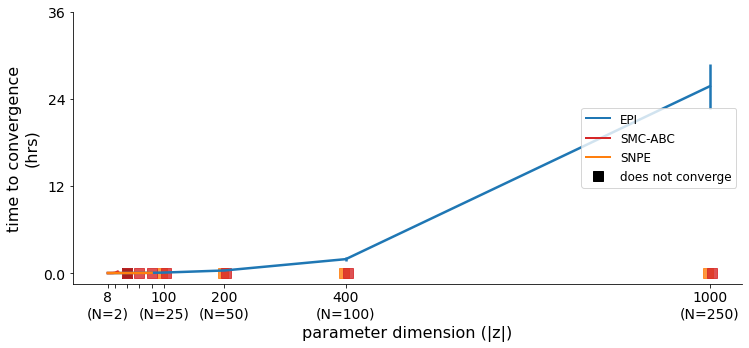

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

N_xs = [2, 25, 50, 100, 250]
xticks = [4*N for N in [2,5,10,15,20,25,50,100,250]]
xtick_labels = ["%d\n(N=%d)" % (D,D//4) if ((D//4) in N_xs) else ''
                for D in xticks]

D_smcs = [4*N for N in N_smcs]
D_snpes = [4*N for N in N_snpes]
D_epis = [4*N for N in N_epis]
yticks = [0., 12, 24, 36]

colors = sns.color_palette()
lw = 2.5
fontsize = 16

ax.plot([0,0],[0,0], '-', c=colors[0], label='EPI')
ax.plot([0,0],[0,0], '-', c=colors[3], label='SMC-ABC')
ax.plot([0,0],[0,0], '-', c=colors[1], label='SNPE')
ax.plot([40,40],[0,0], 's', c='k', label='does not converge')
ax.errorbar(x=D_epis, y=epi_time_mean, yerr=epi_time_std, 
            color=colors[0], ecolor=colors[0], lw=lw)
ax.errorbar(x=D_smcs, y=smc_time_mean, yerr=smc_time_std, 
            color=colors[3], ecolor=colors[3], lw=lw)
ax.errorbar(x=D_snpes, y=snpe_time_mean, yerr=snpe_time_std, 
            color=colors[1], ecolor=colors[1], lw=lw)

SMC_fails = np.array([40, 60, 80, 100, 200, 400, 1000])
SMC_fails[3:]+=3
SNPE_fails = np.array([100, 200, 400, 1000])-3
ax.plot(SNPE_fails, np.zeros(len(SNPE_fails)), 's', c=colors[1], clip_on=False, alpha=0.8)
ax.plot(SMC_fails, np.zeros(len(SMC_fails)), 's', c=colors[3], clip_on=False, alpha=0.8)

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=fontsize-2)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=fontsize-2)

ax.set_xlabel('parameter dimension (|z|)', fontsize=fontsize)
ax.set_ylabel('time to convergence\n(hrs)', fontsize=fontsize)

#ax.set_ylim([0, 3])
ax.legend(fontsize=fontsize-4, loc=5)
plt.show()

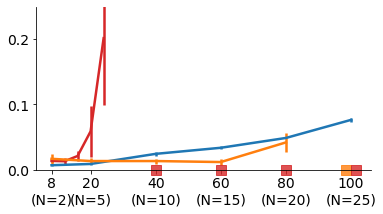

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

N_xs = [2, 5, 10, 15, 20, 25]
xticks = [4*N for N in [2,5,10,15,20,25]]
xtick_labels = ["%d\n(N=%d)" % (D,D//4) if ((D//4) in N_xs) else ''
                for D in xticks]

_N_epis = N_xs
_epi_time_mean = epi_time_mean[:len(_N_epis)]
_epi_time_std = epi_time_std[:len(_N_epis)]

D_smcs = [4*N for N in N_smcs]
D_snpes = [4*N for N in N_snpes]
D_epis = [4*N for N in _N_epis]
yticks = [0., 0.1, 0.2]

colors = sns.color_palette()
lw = 2.5
fontsize = 16

ax.errorbar(x=D_epis, y=_epi_time_mean, yerr=_epi_time_std, 
            color=colors[0], ecolor=colors[0], lw=lw, label='EPI')
ax.errorbar(x=D_smcs, y=smc_time_mean, yerr=smc_time_std, 
            color=colors[3], ecolor=colors[3], lw=lw, label='SMC')
ax.errorbar(x=D_snpes, y=snpe_time_mean, yerr=snpe_time_std, 
            color=colors[1], ecolor=colors[1], lw=lw, label='SNPE')

SMC_fails = np.array([40, 60, 80, 100], dtype=np.float32)
SMC_fails[3:] += 1.5
SNPE_fails = np.array([100])-1.5
ax.plot(SNPE_fails, np.zeros(len(SNPE_fails)), 's', c=colors[1], clip_on=False, alpha=0.8)
ax.plot(SMC_fails, np.zeros(len(SMC_fails)), 's', c=colors[3], clip_on=False, alpha=0.8)

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=fontsize-2)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=fontsize-2)
ax.set_ylim([0, .25])
plt.show()

In [ ]:
import scipy


def eig_scatter(T_x, c='k', ax=None, label=None):
    alpha = 0.7
    grayval = 0.6
    gray = grayval*np.ones(3)
    
    if T_x is None:
        return None
    J_real_max_eig = T_x[:,0]
    Js_max_eig = T_x[:,1]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot([0.5], [1.5], '*', c=gray, markersize=10)
    ax.plot([0, 0], [1, 2], '--', c=gray)
    ax.plot([1, 1], [1, 2], '--', c=gray)
    ax.plot([0, 1], [2, 2], '--', c=gray)
    ax.plot([0, 1], [1, 1], '--', c=gray)
    ax.scatter(J_real_max_eig, Js_max_eig, 
               color=c, edgecolors='k', 
               alpha=alpha, label=label)
    return None

def sim_r2RNN(z, N, M, t):
    U = np.reshape(z[:,:(2*N)], (-1, N, 2))
    V = np.reshape(z[:,(2*N):], (-1, N, 2))
    J = np.matmul(U, np.transpose(V, [0,2,1]))

    r_ts = []
    for m in range(M):
        _J = J[m] + 0.0*np.eye(N)
        f = lambda r, t : (1/0.1)*(-r + np.dot(_J, r))
        u, s, v = np.linalg.svd(_J, full_matrices=False)
        r_R_t = scipy.integrate.odeint(f, v[0], t)
        r_ts.append(np.linalg.norm(r_R_t, axis=1))
    r_ts = np.array(r_ts)
    return r_ts

t = np.linspace(0,2,201)

N_plot_eigs = [2,5,10,15,250]
num_cols = len(N_plot_eigs)
n_plot = 200
n_traces = 25
lw = .8
alpha = .6
yticks = [0,1,2,3,4]
fontsize=18
fig, axs = plt.subplots(2,num_cols,figsize=(3*num_cols,6))
for i, N in enumerate(N_plot_eigs):
    ax = axs[0][i]
    z_smc, z_snpe, z_epi = None, None, None
    T_x_smc, T_x_snpe, T_x_epi = None, None, None
    r_t_smc, r_t_snpe, r_t_epi = None, None, None
    # Load zs, T_xs
    t = np.linspace(0,2,201)
    if N in N_snpes:
        if not N == 25:
            ind = 0 if N < 20 else 1
            z_snpe = snpe_zs[N_snpes.index(N)][ind][:n_plot,:]
            T_x_snpe = snpe_T_xs[N_snpes.index(N),ind][:n_plot,:]
            r_t_snpe = sim_r2RNN(z_snpe, N, n_traces, t)
    if N in N_epis:
        ind = 1 if not N==100 else 0
        if N==250:
            ind = 0
            t = np.linspace(0,0.2,201)
        z_epi = epi_zs[N_epis.index(N)][ind][:n_plot,:]
        T_x_epi = epi_T_xs[N_epis.index(N),ind][:n_plot,:]
        r_t_epi = sim_r2RNN(z_epi, N, n_traces, t)
    if N in N_smcs:
        z_smc = np.concatenate(smc_zs[N_smcs.index(N)][:,:(n_plot//10),:], axis=0)
        T_x_smc = np.concatenate(smc_T_xs[N_smcs.index(N)][:,:(n_plot//10),:], axis=0)
        r_t_smc = sim_r2RNN(z_smc, N, n_traces, t)
        
    # Sim from network parameters
    
    eig_scatter(T_x_snpe, c=colors[1], ax=ax, label='SNPE')
    eig_scatter(T_x_epi, c=colors[0], ax=ax, label='EPI')
    eig_scatter(T_x_smc, c=colors[3], ax=ax, label='SMC-ABC')
    ax.set_xlim([-1, 3])
    ax.set_ylim([0, 4])
    ax.set_yticks(yticks)
    if (i==0):
        ax.set_ylabel(r'$\lambda^s_1$', fontsize=fontsize)
        ax.set_yticklabels(yticks, fontsize=(fontsize-2))
        ax.legend(fontsize=(fontsize-4), framealpha=0.2, loc=2)
    else:
        ax.set_yticklabels(len(yticks)*[''])
    ax.set_xlabel(r'real($\lambda_1$)', fontsize=fontsize)
    ax.set_title('N = %d' % (N), fontsize=(fontsize+2))
    
    ax = axs[1][i]
    if r_t_snpe is not None:
        ax.plot(t, r_t_snpe.T, c=colors[1], lw=lw, alpha=alpha)
    if r_t_smc is not None:
        ax.plot(t, r_t_smc.T, c=colors[3], lw=lw, alpha=alpha)
    if r_t_epi is not None:
        ax.plot(t, r_t_epi.T, c=colors[0], lw=lw+.1, alpha=alpha)
    if i==0:
        ax.set_ylabel(r'$|r(t)|$', fontsize=fontsize)
    ax.set_xlabel('time (s)', fontsize=fontsize)
    ax.set_ylim([0,5])
plt.tight_layout()
plt.show()